[Competition on Kaggle](https://www.kaggle.com/c/word2vec-nlp-tutorial)

First model: classical approach based on TF-IDF and logistic regression.

Second model: word embeddings are averaged and logistic regression is trained.

In [ ]:
!pip install kaggle -q

In [ ]:
%%bash
gdown --id 18LusyPD-hERgBhIzsYJPmz8OYD6wmv5k -q
mkdir /root/.kaggle
mv kaggle.json /root/.kaggle/
kaggle competitions download word2vec-nlp-tutorial
unzip -q word2vec-nlp-tutorial.zip -d dataset
rm word2vec-nlp-tutorial.zip

unzip -q dataset/labeledTrainData.tsv.zip -d dataset
unzip -q dataset/testData.tsv.zip -d dataset
unzip -q dataset/unlabeledTrainData.tsv.zip -d dataset
rm dataset/labeledTrainData.tsv.zip
rm dataset/testData.tsv.zip
rm dataset/unlabeledTrainData.tsv.zip

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
100%|██████████| 51.7M/51.7M [00:01<00:00, 28.3MB/s]


In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from bs4 import BeautifulSoup
import nltk
import torch
from tqdm.notebook import tqdm

from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
df_train = pd.read_csv('dataset/labeledTrainData.tsv', sep='\t')

In [ ]:
df_train.drop(columns=['id'], inplace=True)
df_train.head()

,sentiment,review
0,1,With all this stuff going down at the moment w...
1,1,"\The Classic War of the Worlds\"" by Timothy Hi..."
2,0,The film starts with a manager (Nicholas Bell)...
3,0,It must be assumed that those who praised this...
4,1,Superbly trashy and wondrously unpretentious 8...


In [ ]:
df_train.isna().sum(0)

sentiment    0
review       0
dtype: int64

In [ ]:
df_train.shape

(25000, 2)

In [ ]:
BeautifulSoup(df_train.review[0]).get_text()

"With all this stuff going down at the moment with MJ i've started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ's feeling towards the press and also the obvious message of drugs are bad m'kay.Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring. Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for the fans which if true is really nice of him.The actual feature film bit when it finally starts is only on for 20 mi

In [ ]:
from nltk.corpus import stopwords
import re
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
en_stopwords = set(stopwords.words('english'))
len(en_stopwords)

179

In [ ]:
def clean_text(text, stopwords=en_stopwords):
  text = BeautifulSoup(text).get_text()
  text = text.lower()

  text = re.sub(r'[^a-zA-Z0-9]', ' ', text)
  text = text.strip()

  return ' '.join(
      [lemmatizer.lemmatize(word) for word in word_tokenize(text) if word not in en_stopwords]
  )

def clean_df(df):
  df['cleaned_review'] = df.review.apply(clean_text)


def tokenize_corpus(texts):
  return [
        word_tokenize(text)
        for text in texts
      ]

#TF-IDF \ Counter Vectorize

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn import metrics


def metric(model, X_train, y_train, X_test, y_test):
  y_train_pred = model.predict(X_train)
  y_test_pred = model.predict(X_test)

  print(
      'Accuracy score:\n\tTrain: {train_score}\n\tTest: {test_score}'.format(
          train_score=metrics.accuracy_score(y_train, y_train_pred),
          test_score=metrics.accuracy_score(y_test, y_test_pred)
      ),
      end='\n\n'
  )

  print(metrics.classification_report(y_test, y_test_pred))

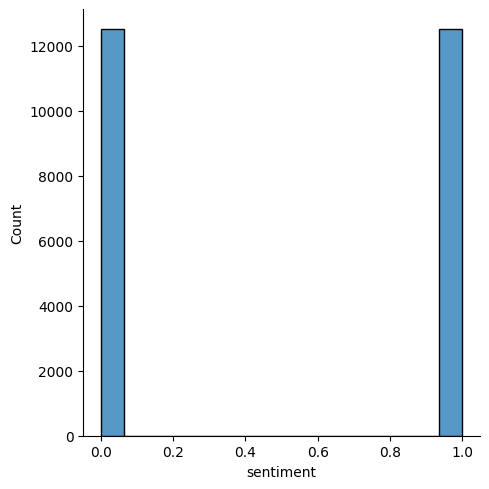

In [ ]:
sns.displot(df_train.sentiment)

In [ ]:
clean_df(df_train)
df_train.head()

,sentiment,review,cleaned_review
0,1,With all this stuff going down at the moment w...,stuff going moment mj started listening music ...
1,1,"\The Classic War of the Worlds\"" by Timothy Hi...",classic war world timothy hines entertaining f...
2,0,The film starts with a manager (Nicholas Bell)...,film start manager nicholas bell giving welcom...
3,0,It must be assumed that those who praised this...,must assumed praised film greatest filmed oper...
4,1,Superbly trashy and wondrously unpretentious 8...,superbly trashy wondrously unpretentious 80 ex...


In [ ]:
pipe = make_pipeline(
    TfidfVectorizer(max_features=5000),
    LogisticRegression()
)

pipe.fit(df_train.cleaned_review.values, df_train.sentiment.values)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer(max_features=5000)),
                ('logisticregression', LogisticRegression())])

In [ ]:
metric(
      pipe,
      df_train.cleaned_review.values,
      df_train.sentiment.values,
      df_train.cleaned_review.values,
      df_train.sentiment.values
    )

Accuracy score:
	Train: 0.91572
	Test: 0.91572

              precision    recall  f1-score   support

           0       0.92      0.91      0.91     12500
           1       0.91      0.93      0.92     12500

    accuracy                           0.92     25000
   macro avg       0.92      0.92      0.92     25000
weighted avg       0.92      0.92      0.92     25000



In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df_train.cleaned_review.values,
    df_train.sentiment.values,
    test_size=.2
)

#pipe.fit(X_train, y_train)

In [ ]:
metric(
    pipe,
    X_train,
    y_train,
    X_test,
    y_test
)

Accuracy score:
	Train: 0.9174
	Test: 0.8874

              precision    recall  f1-score   support

           0       0.90      0.87      0.88      2476
           1       0.88      0.90      0.89      2524

    accuracy                           0.89      5000
   macro avg       0.89      0.89      0.89      5000
weighted avg       0.89      0.89      0.89      5000



#Word2Vec

In [ ]:
!pip install gensim

In [ ]:
unlabeled = pd.read_csv('dataset/unlabeledTrainData.tsv', sep='\t', quoting=3)

In [ ]:
clean_df(unlabeled)
unlabeled.head()

,id,review,cleaned_review
0,"""9999_0""","""Watching Time Chasers, it obvious that it was...",watching time chaser obvious made bunch friend...
1,"""45057_0""","""I saw this film about 20 years ago and rememb...",saw film 20 year ago remember particularly nas...
2,"""15561_0""","""Minor Spoilers<br /><br />In New York, Joan B...",minor spoilersin new york joan barnard elvire ...
3,"""7161_0""","""I went to see this film with a great deal of ...",went see film great deal excitement school dir...
4,"""43971_0""","""Yes, I agree with everyone on this site this ...",yes agree everyone site movie bad even call mo...


In [ ]:
unlabeled.shape[0] + df_train.shape[0]

75000

In [ ]:
texts = np.concatenate([
    df_train.cleaned_review.values,
    unlabeled.cleaned_review.values
], axis=0)

In [ ]:
corpus = tokenize_corpus(texts)

In [ ]:
EMB_DIM = 300
WINDOW = 5

In [ ]:
from gensim.models import Word2Vec

w2v_model = Word2Vec(
    vector_size=EMB_DIM,
    window=WINDOW,
    min_count=30,
    #max_vocab_size=5000
    )


In [ ]:
w2v_model.build_vocab(corpus)

In [ ]:
w2v_model.wv.most_similar('man')

[('reject', 0.2643938362598419),
 ('jc', 0.23375603556632996),
 ('fierce', 0.23290351033210754),
 ('redgrave', 0.21658024191856384),
 ('mozart', 0.20049916207790375),
 ('shriek', 0.19929784536361694),
 ('wishman', 0.19423554837703705),
 ('title', 0.19418597221374512),
 ('enchanting', 0.19292251765727997),
 ('bystander', 0.19284337759017944)]

In [ ]:
%%time
w2v_model.train(corpus, total_examples=w2v_model.corpus_count, epochs=50)

CPU times: user 36min 39s, sys: 6.5 s, total: 36min 45s
Wall time: 21min 37s


(411731201, 455116300)

In [ ]:
w2v_model.wv.most_similar('man')

[('men', 0.5579754710197449),
 ('woman', 0.4747456908226013),
 ('guy', 0.44695907831192017),
 ('person', 0.43832606077194214),
 ('lady', 0.41754403710365295),
 ('boy', 0.4001023471355438),
 ('husband', 0.3782379627227783),
 ('son', 0.36361825466156006),
 ('father', 0.33693820238113403),
 ('girl', 0.329302579164505)]

In [ ]:
w2v_model.wv.vector_size

300

In [ ]:
w2v_model.save('model.pt')

# Average Embeddings

In [ ]:
def get_embedding(sent, wv=w2v_model.wv):
  res = []
  for word in sent.split():
    if word in wv:
      res.append(wv[word])

  if len(res) == 0: return np.zeros(wv.vector_size)
  return np.stack(res, axis=0).mean(axis=0)


In [ ]:
from torch.utils.data import Dataset, DataLoader

In [ ]:
class EmbedsDataset(Dataset):
  def __init__(self, texts, targets, wv=w2v_model.wv):
    self.texts = texts
    self.targets = targets
    self.wv = wv

  def __len__(self):
    return len(self.texts)

  def __getitem__(self, idx):
    embed = torch.tensor(get_embedding(self.texts[idx], wv=self.wv), dtype=torch.float32)
    target = self.targets[idx]
    return embed, target


train_set = EmbedsDataset(X_train, y_train)
test_set = EmbedsDataset(X_test, y_test)

train_loader = DataLoader(
    train_set,
    shuffle=True,
    batch_size=128,
    pin_memory=True,
    num_workers=8
)

test_loader = DataLoader(
    test_set,
    shuffle=False,
    batch_size=128,
    pin_memory=True,
    num_workers=8
)

In [ ]:
import torch.nn as nn

class MyLogisticRegression(nn.Module):
  def __init__(self, in_features=EMB_DIM, out_features=1):
    super().__init__()
    self.linear = nn.Linear(in_features, out_features)

  def forward(self, x):
    return self.linear(x)

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm.notebook import tqdm


def plot_losses(train_losses, test_losses, train_accuracies, test_accuracies):
    clear_output()
    fig, axs = plt.subplots(1, 2, figsize=(13, 4))
    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='train', color='deepskyblue', linewidth=2)
    axs[0].plot(range(1, len(test_losses) + 1), test_losses, label='test', color='springgreen', linewidth=2)
    axs[0].set_ylabel('loss')

    axs[1].plot(range(1, len(train_accuracies) + 1), train_accuracies, label='train',
                color='deepskyblue', linewidth=2)
    axs[1].plot(range(1, len(test_accuracies) + 1), test_accuracies, label='test',
                color='springgreen', linewidth=2)
    axs[1].set_ylabel('accuracy')

    for ax in axs:
        ax.set_xlabel('epoch')
        ax.legend()

    plt.show()

In [ ]:
def training_epoch(model, optimizer, criterion, train_loader, tqdm_desc):
    train_loss, train_accuracy = 0.0, 0.0
    model.train()
    for embeds, labels in tqdm(train_loader, desc=tqdm_desc):
        embeds = embeds.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        logits = model(embeds)
        probs = nn.functional.sigmoid(logits).squeeze(1)
        loss = criterion(probs, labels.float())
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * embeds.shape[0]
        train_accuracy += ((probs > .5).type(torch.float32) == labels).cpu().sum().item()

    train_loss /= len(train_loader.dataset)
    train_accuracy /= len(train_loader.dataset)
    return train_loss, train_accuracy

@torch.no_grad()
def validation_epoch(model, criterion, valid_loader, tqdm_desc):
    valid_loss, valid_accuracy = 0.0, 0.0
    model.eval()
    for embeds, labels in tqdm(valid_loader, desc=tqdm_desc):
        embeds = embeds.to(device)
        labels = labels.to(device)

        logits = model(embeds)
        probs = nn.functional.sigmoid(logits).squeeze(1)
        loss = criterion(probs, labels.float())

        valid_loss += loss.item() * embeds.shape[0]
        valid_accuracy += ((probs > .5).type(torch.float32) == labels).cpu().sum().item()

    valid_loss /= len(valid_loader.dataset)
    valid_accuracy /= len(valid_loader.dataset)
    return valid_loss, valid_accuracy


def train(model, optimizer, scheduler, criterion, train_loader, valid_loader, num_epochs):
    train_losses, valid_losses = [], []
    train_accuracies, valid_accuracies = [], []

    for epoch in range(1, num_epochs + 1):
        train_loss, train_accuracy = training_epoch(
            model, optimizer, criterion, train_loader,
            tqdm_desc=f'Training {epoch}/{num_epochs}'
        )
        valid_loss, valid_accuracy = validation_epoch(
            model, criterion, valid_loader,
            tqdm_desc=f'Validating {epoch}/{num_epochs}'
        )

        if scheduler is not None:
            scheduler.step()

        train_losses += [train_loss]
        train_accuracies += [train_accuracy]
        valid_losses += [valid_loss]
        valid_accuracies += [valid_accuracy]
        plot_losses(train_losses, valid_losses, train_accuracies, valid_accuracies)

In [ ]:
NUM_EPOCHS = 30
model = MyLogisticRegression().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, NUM_EPOCHS)
criterion = nn.BCELoss()

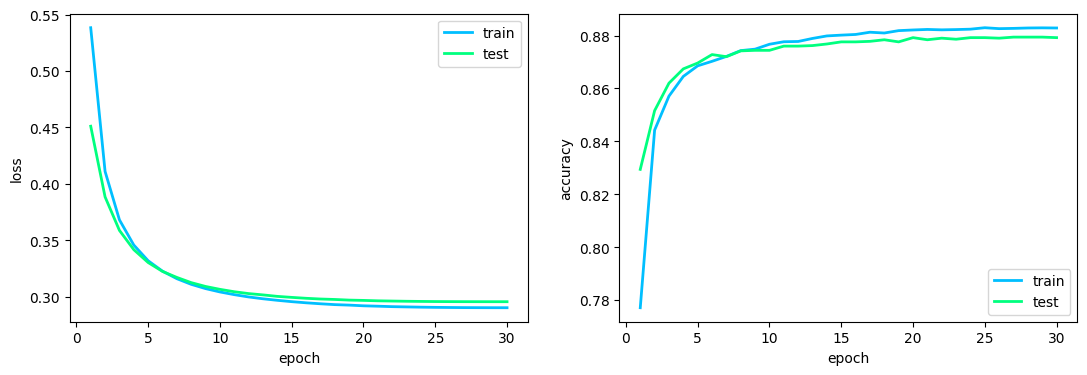

In [ ]:
train(model, optimizer, scheduler, criterion, train_loader, test_loader, NUM_EPOCHS)

In [ ]:
nn.functional.sigmoid(torch.tensor(3))

tensor(0.9526)